In [1]:
# import standard libraries
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# import our libraries
import bayes_helpers as bh
from utils import generate_data, run_toy_nn
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

### Define LUNA Hyperparameters

### Generate Cubic Dataset

Generates 100 datapoints for train and 100 points for test according to the function

$$y = \frac{1}{2}x^3 + \epsilon$$

$$\epsilon \sim N(0, 3^2)$$

In [2]:
x_train, y_train, x_test = generate_data()

######################
### COMMMON PARAMS####
######################


####  activation function ####
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

#### optimization parameters ####
optimization_params = {'step_size':1e-3, 
          'max_iteration':1000, 
          'random_restarts':1,
          'optimizer':'adam'}

#### model parameters #####
prior_variance = 1 # chosen in the paper. declared "reasonable". who decided this
y_noise_variance = 9 # needs to match what the dataset itself is

#### other ####
random_seed = np.random.RandomState(0)

########################
#### LUNA SPECIFIC  ####
########################

luna_architecture = {'width': 50,
            'hidden_layers': 2,
            'input_dim': 1,
            'output_dim': 5, #number of auxiliary functions, # note, in NLM, below, we change to 1
            'activation_fn_type': activation_fn_type,
            'activation_fn_params': 'rate=1',
            'activation_fn': activation_fn}

regularization_param_luna = 1e-1 # in the paper they searched over 1e-3,...,1e3 and chose 1e-1 for regularization

similarity_param = 1e0 # in the paper they searched over 1e-3,...,1e3 and chose 1e0 for similarity

In [3]:
from autograd import numpy as np

training_sample_size = 100

######################
### Model Params
######################
prior_variance = 1 # chosen in the paper. declared "reasonable". who decided this
y_noise_variance = 9 # needs to match what the dataset itself is

######################
### Feed Forward Params
######################

####  activation function ####
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

#### optimization parameters ####
opt_params = {'step_size':1e-3,
          'max_iteration':100,
          'random_restarts':1,
          'optimizer':'adam'}

random_seed = np.random.RandomState(0)

real_max_iteration = 3500

########################
#### LUNA SPECIFIC  ####
########################

    # takes about 2 minutes to run

luna_architecture = {'width': 50,
            'hidden_layers': 2,
            'input_dim': 1,
            'output_dim': 50, #number of auxiliary functions, # note, in NLM, below, we change to 1
            'activation_fn_type': activation_fn_type,
            'activation_fn_params': 'rate=1',
            'activation_fn': activation_fn}

regularization_param_luna = 1e-1 # in the paper they searched over 1e-3,...,1e3 and chose 1e-1 for regularization

similarity_param = 1e0 # in the paper they searched over 1e-3,...,1e3 and chose 1e0 for similarity

In [4]:
#JACK
# Edit grad_func_specs dictionary for fixed step sizes

grad_func_specs_1 = {'fixed' : 0.1}
grad_func_specs_001 = {'fixed' : 0.001}
grad_func_specs_0001 = {'fixed' : 0.0001}

### Train LUNA

`luna_base` uses the default settings of an array of step sizes chosen from `np.random.normal(0,0.1,size=10)`

`luna_1` uses a column of fixed step size = 0.1

`luna_001` uses a column of fixed step size = 0.001

`luna_0001` uses a column of fixed step size = 0.0001

In [7]:
t0 = time.time()
luna_base = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed)
luna_base.train(x_train, y_train, opt_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 0 lower bound 354751.32461733685; gradient mag: 183305.90292451478
Done Training
time: 75.237 seconds


In [9]:
t0 = time.time()
luna_1 = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed, grad_func_specs= grad_func_specs_1)
luna_1.train(x_train, y_train, opt_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 0 lower bound 462948.49838927086; gradient mag: 218113.50059469556
Done Training
time: 78.21 seconds


In [10]:
t0 = time.time()
luna_001 = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed, grad_func_specs= grad_func_specs_001)
luna_001.train(x_train, y_train, opt_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 0 lower bound 491157.6626256347; gradient mag: 227216.3329083367
Done Training
time: 80.342 seconds


In [11]:
t0 = time.time()
luna_0001 = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed, grad_func_specs= grad_func_specs_0001)
luna_0001.train(x_train, y_train, opt_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 0 lower bound 300910.3179570639; gradient mag: 158527.73562194532
Done Training
time: 85.034 seconds


### Compare Results

- Appears like they have a reduced "uncertainty" where we should see more.  In other words, the random step size helps to give more predictive uncertainty

- Calculate MSE as a quantative metric?

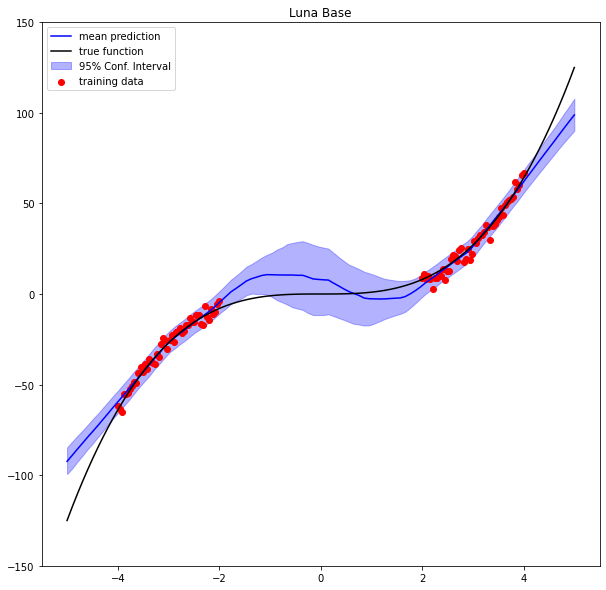

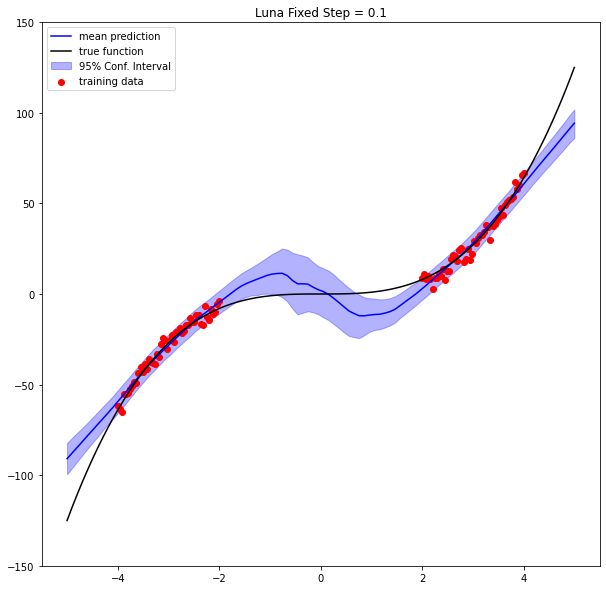

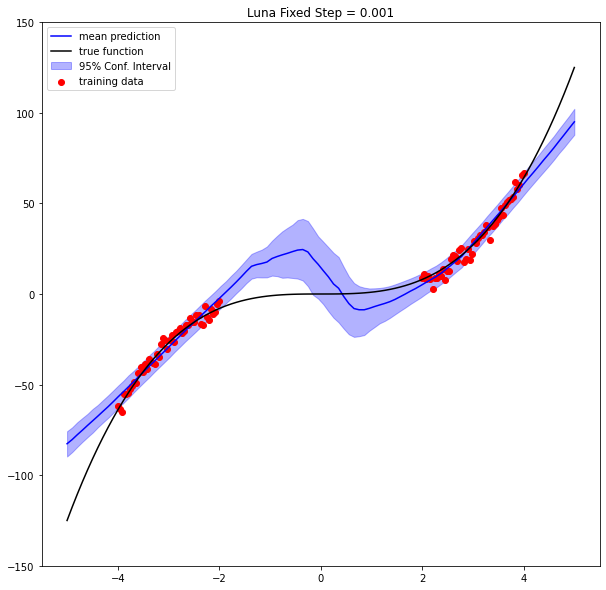

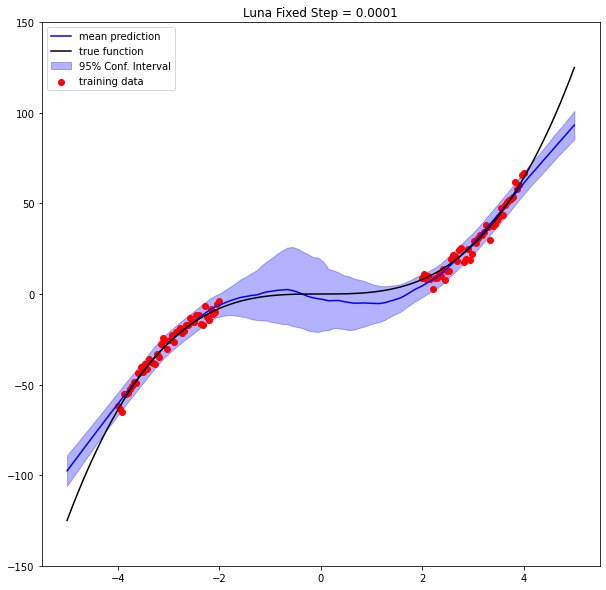

In [12]:
# fig, ax = plt.subplots(1,2, figsize = (12, 6))
i = 0
for name, model in {"Luna Base":luna_base, "Luna Fixed Step = 0.1": luna_1, "Luna Fixed Step = 0.001": luna_001,
                   "Luna Fixed Step = 0.0001": luna_0001,}.items():
    posterior_predictions, posterior_predictive_samples = model.predict(x_test)
    bh.viz_pp_samples(x_train, y_train,x_test.flatten(),posterior_predictive_samples,name)